In [3]:
import numpy as np
import math

In [172]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [5]:
a = Value(2)
b = Value(3)
a,b

(Value(2), Value(3))

In [6]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

In [7]:
d._op

'+'

In [8]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


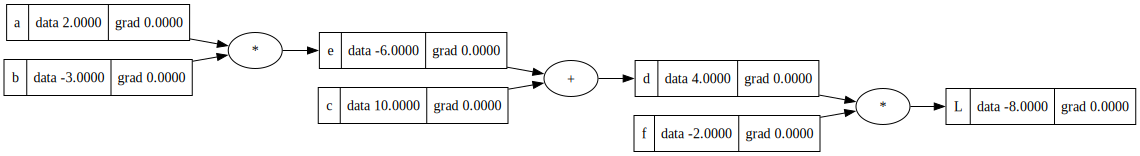

In [9]:
draw_dot(L)

# Manual back propgation

gradiant at current point of L with respect to each variable (which will be weigght in NN)

for calculation can use limit format == f(x+h) - f(x) / h    h---> 0 this will be the rate of change at that point of x or differentiation

1. dL/dd = d(d*f)/dd = f
2. dL/df = d(d*f)/df = d

## Chain rule
since now they are not directly connected to L we will use chain rule

3. dL/dc = dL/dd * dd/dc  = f * d(e+c)/de = f*1
4. dL/de = dL/dd * dd/de  = f * d(e+c)/de = f*1

5. dL/da = dL/de * de/da = f * d(a*b)/da = f*b
6. dL/db = dL/de * de/db = f * d(a*b)/da = f*a


In [10]:
d.grad = f.data
f.grad = d.data
e.grad = d.grad * 1
c.grad = d.grad * 1 
a.grad = e.grad * b.data
b.grad = e.grad * a.data


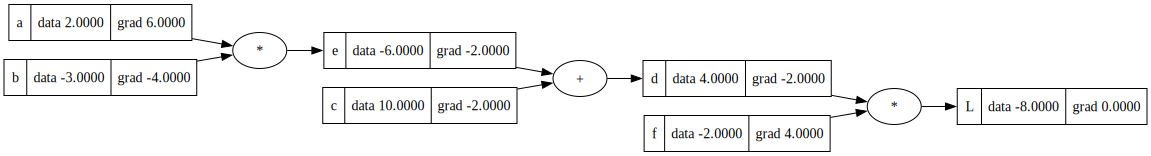

In [11]:
draw_dot(L)

# Nueral network implementaion manual

single neuron with two input

In [12]:
#input values
x1 = Value(2.0, label='x1')
x2 = Value(3.0, label='x2')

#weights
w1 = Value(4.0, label='w1')
w2 = Value(-5.0, label='w2')

#bias
b = Value(6.0, label='b')

#output
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
z = x1w1x2w2 + b; z.label = 'z'
y = z.tanh(); y.label = 'y'

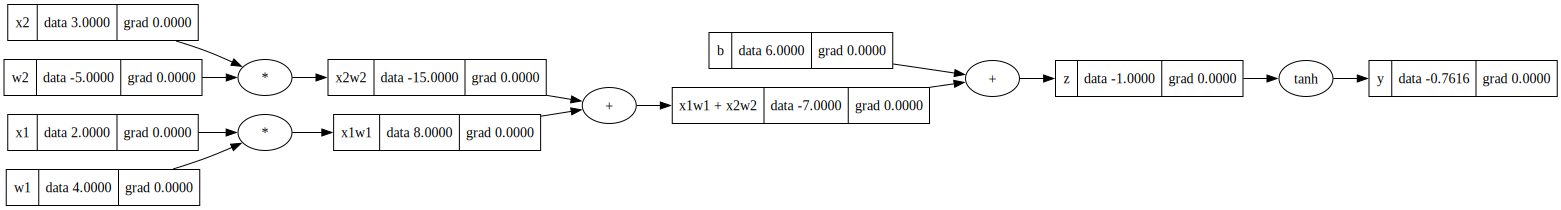

In [13]:
draw_dot(y)

# Manual back propogation for neuron
rate of change pf y with respect to other variables 

In [14]:
y.grad = 1.0
z.grad = 1 - y.data**2  #diff of tanh dy/dz = 1-(tanh z)^2 = 1 - y^2
b.grad = z.grad * 1
x1w1x2w2.grad = z.grad * 1  #plus operation same as derivative of parent
x1w1.grad = x1w1x2w2.grad 
x2w2.grad = x1w1x2w2.grad #plus operation same as derivative of parent
x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data 


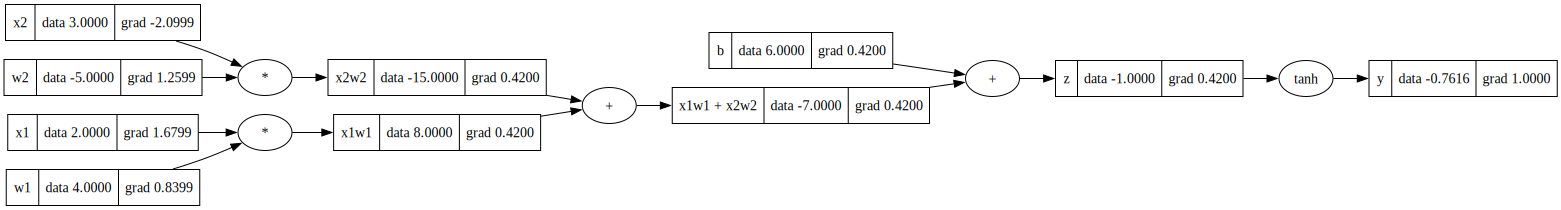

In [15]:
draw_dot(y)

# Back propgation automatic

now since we know how the gradient flows with respect to each operation +,*,tanh we can find the grad from the value of self and grad of its parent

we will define self._backwar = lambda: None #a funcntion which does nothing by default

we will create and set this function to object in each operation __add__, __mul__ etc

set up in the Value class
rec create the NN and verify the auto grad

In [16]:
#input values
x1 = Value(2.0, label='x1')
x2 = Value(3.0, label='x2')

#weights
w1 = Value(4.0, label='w1')
w2 = Value(-5.0, label='w2')

#bias
b = Value(6.0, label='b')

#output
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
z = x1w1x2w2 + b; z.label = 'z'
y = z.tanh(); y.label = 'y'

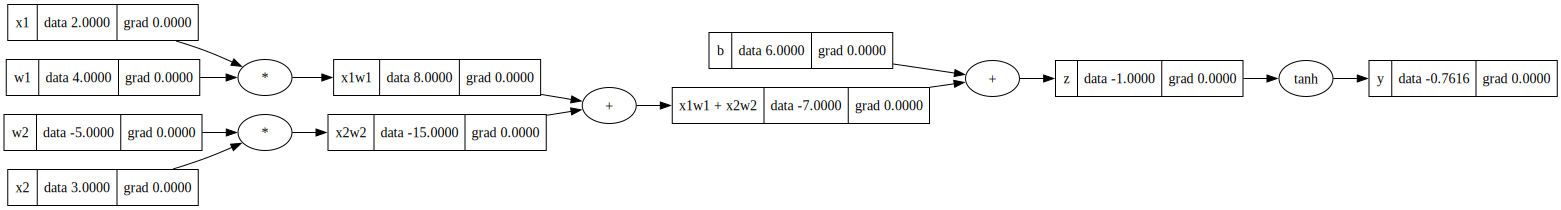

In [17]:
draw_dot(y)

In [18]:
y.grad = 1.0 # for the final output, we set the gradient to 1.0
y._backward()
z._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()


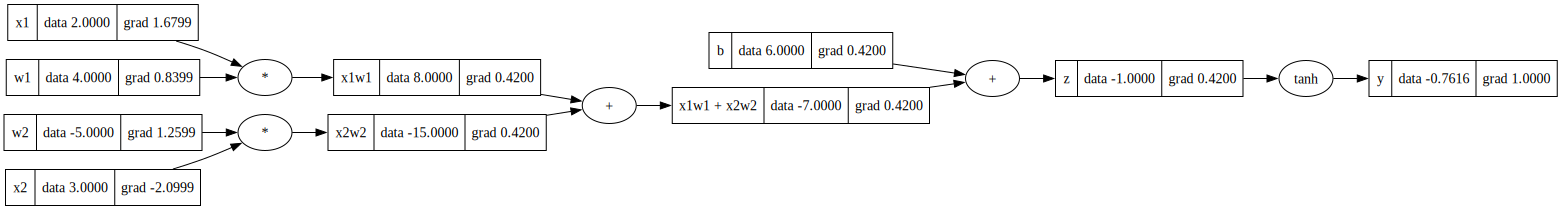

In [19]:
draw_dot(y)

#### In case a single chile have multiple parent then in that case if we set grad as '=' then it will over write the gradinet we ewant to accumulate it so we will use +=

# Topology

the order of calling the backpropogation matters, last value should be called first for gradient then its childs in order . To do that we use topological sort

In [20]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        
        topo.append(v)
    

In [21]:
build_topo(y)
topo

[Value(6.0),
 Value(4.0),
 Value(2.0),
 Value(8.0),
 Value(-5.0),
 Value(3.0),
 Value(-15.0),
 Value(-7.0),
 Value(-1.0),
 Value(-0.7615941559557649)]

In [22]:
# the final element in topo is the output, so we can call its backward function to start the backpropagation

# autpgrad using topology

In [23]:
#NN
#input values
x1 = Value(2.0, label='x1')
x2 = Value(3.0, label='x2')

#weights
w1 = Value(4.0, label='w1')
w2 = Value(-5.0, label='w2')

#bias
b = Value(6.0, label='b')

#output
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
z = x1w1x2w2 + b; z.label = 'z'
y = z.tanh(); y.label = 'y'

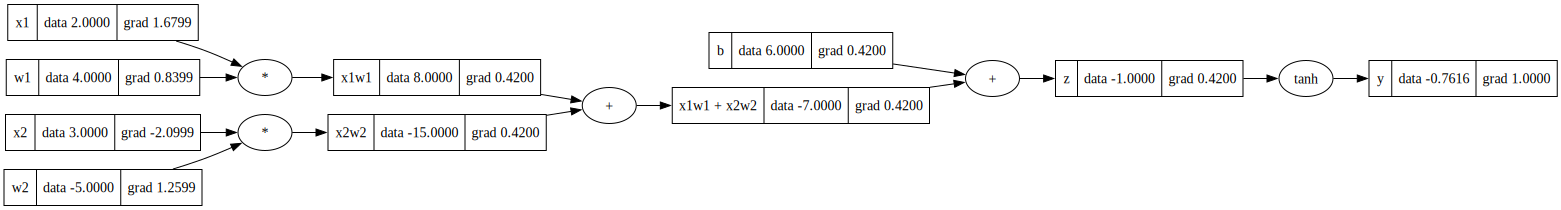

In [24]:
y.backward()  # start the backpropagation from the output value
draw_dot(y)

In [25]:
build_topo(y)
y.grad = 1.0  # for the final output, we set the gradient to 1.0
for v in reversed(topo):
    v._backward()  # call the backward function of each value in reverse order

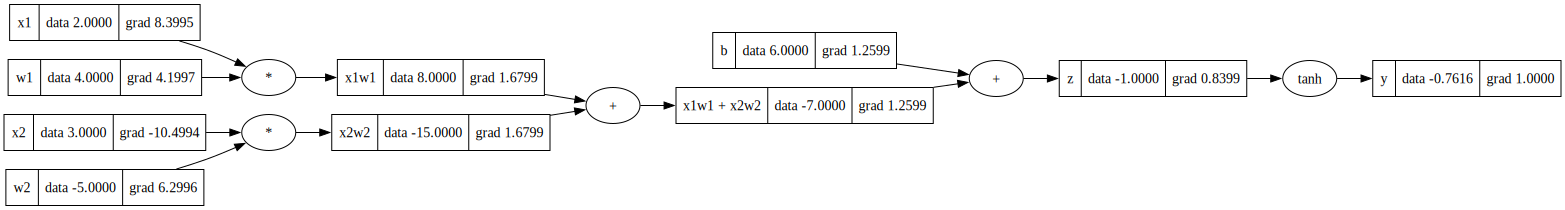

In [146]:
draw_dot(y)

Now we can incorporate this in our class 

# Neural Network

In [223]:
class Neuron:

    def __init__(self,n_input):
        self.W = [Value(np.random.uniform(-1,1)) for _ in range(n_input)]
        self.b = Value(np.random.uniform(-1,1))

    def __call__(self, x):

        assert len(x) == len(self.W), "Input size must match number of weights"
        #z = w.x +b
        act = self.b
        for wi, xi in zip(self.W, x):
            act = act + (wi * xi)
        out = act.tanh()  # apply activation function
        return out
    
    def parameters(self):
        return self.W + [self.b]
    
class Layer:

    def __init__(self, n_input, n_neurons):
        self.neurons = [Neuron(n_input) for _ in range(n_neurons)]
    
    def __call__(self, x):
        assert len(x) == len(self.neurons[0].W), "Input size must match number of weights"
        out = [n(x) for n in self.neurons]
        return out
    
    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]
    
class MLP:

    def __init__(self, n_input, layer_sizes : list):
        self.layers = []
        input = n_input
        for layer_size in layer_sizes:
            self.layers.append(Layer(input, layer_size))
            input = layer_size

    def __call__(self, x):

        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
    

In [224]:
x = [Value(2.0), Value(3.0)]
n = Neuron(2)
n(x)

Value(data=0.148114884206705)

In [225]:
l = Layer(2, 3)


In [226]:
l(x)

[Value(data=0.9875564077014798),
 Value(data=-0.9444316256409746),
 Value(data=-0.9926761049747758)]

In [227]:
mlp = MLP(2, layer_sizes=[2, 3,1])

In [228]:
mlp(x)

[Value(data=0.07505057259995221)]

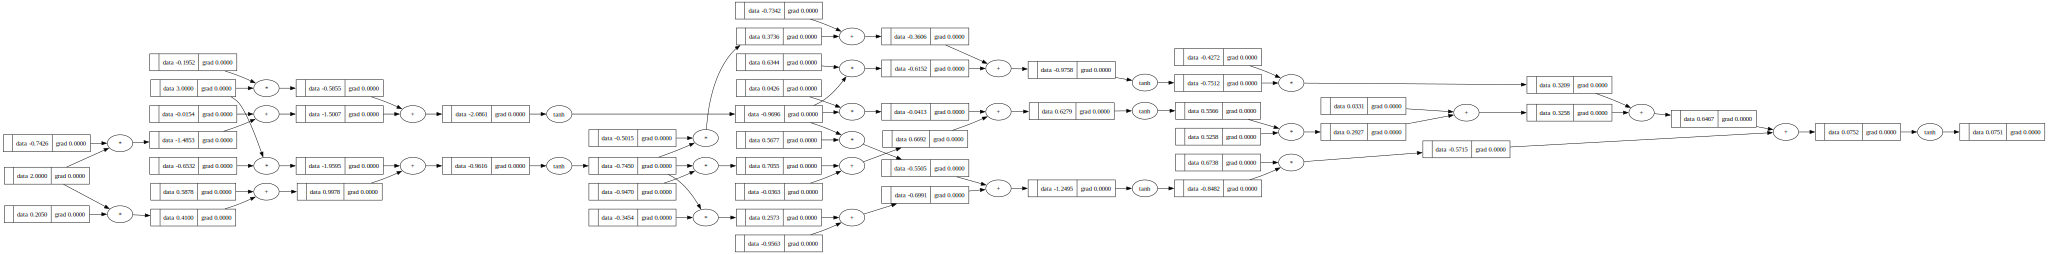

In [229]:
draw_dot(mlp(x)[0])

# Example NN dataset

In [409]:
xs = [[Value(2.0), Value(3.0), Value(-1.0)],
      [Value(3.0), Value(-1.0), Value(0.5)],
      [Value(0.5), Value(1.0), Value(1.0)],
      [Value(1.0), Value(1.0), Value(-1.0)]]

ys = [[Value(1.0)],
      [Value(-1.0)],
        [Value(-1.0)],
        [Value(1.0)]]

In [410]:
mlp = MLP(3, layer_sizes=[2, 3, 1])

In [411]:
ypred = [mlp(x) for x in xs]

In [412]:
ypred

[[Value(data=-0.2687476293493907)],
 [Value(data=-0.9637743172097197)],
 [Value(data=-0.8592188027385059)],
 [Value(data=-0.8021244917556135)]]

# Implementing the loss function, optimizers"

In [413]:
#MSE

loss = sum([(ygt[0]-yout[0])**2 for ygt,yout in zip(ys, ypred)])

In [414]:
loss

Value(data=4.878504876361129)

In [415]:
loss.backward()

In [416]:
mlp.layers[0].neurons[0].W[0].grad

-0.6308666729389208

In [417]:
mlp.layers[0].neurons[0].parameters() #w ==3 w + 1 b

[Value(data=-0.2058376467773877),
 Value(data=0.5102110757510223),
 Value(data=-0.9301639001411033),
 Value(data=-0.11310126520989328)]

In [418]:
mlp.parameters()

[Value(data=-0.2058376467773877),
 Value(data=0.5102110757510223),
 Value(data=-0.9301639001411033),
 Value(data=-0.11310126520989328),
 Value(data=-0.605302186959843),
 Value(data=0.7736001693177912),
 Value(data=0.36221651914444486),
 Value(data=-0.30666344029405646),
 Value(data=0.38566372829850737),
 Value(data=0.9262079655620701),
 Value(data=-0.2757291090015723),
 Value(data=-0.8372197699835748),
 Value(data=-0.3039542255337586),
 Value(data=0.7360984941337807),
 Value(data=0.8548516248236926),
 Value(data=0.675028293009222),
 Value(data=-0.33664067671482556),
 Value(data=0.6847333585541258),
 Value(data=-0.7051970653968169),
 Value(data=-0.008578335696233008),
 Value(data=-0.7091060773703484)]

### now we have individual parameters and their individua; gradients.
Now we can start optimizing

In [419]:
learning_rate = 0.01
#parameter to monitor 
mlp.layers[0].neurons[0].W[0].data, mlp.layers[0].neurons[0].W[0].grad

(-0.2058376467773877, -0.6308666729389208)

In [420]:
for p in mlp.parameters():
    p.data -= learning_rate * p.grad  # simple gradient descent step

In [421]:
mlp.layers[0].neurons[0].W[0].data, mlp.layers[0].neurons[0].W[0].grad

(-0.1995289800479985, -0.6308666729389208)

reduced by a tiny amount as grad was positive

In [422]:
#new preds and loss
ypred = [mlp(x) for x in xs]
loss = sum([(ygt[0]-yout[0])**2 for ygt,yout in zip(ys, ypred)])

In [423]:
loss 

Value(data=4.117632292676667)

loss reduced , so optimization successfull repeating this process will become training

In [468]:
for _ in range(100):

    #forward pass
    ypred = [mlp(x) for x in xs]
    loss = sum([(ygt[0]-yout[0])**2 for ygt,yout in zip(ys, ypred)])

    
    #backward pass
    for p in mlp.parameters():
        p.grad = 0.0 # reset gradients before backpropagation
    loss.backward()
    
    #gradient descent step
    for p in mlp.parameters():
        p.data -= learning_rate * p.grad  # simple gradient descent step

In [469]:
loss, ypred

(Value(data=0.0021158925263539833),
 [[Value(data=0.9818107264152395)],
  [Value(data=-0.996039127928001)],
  [Value(data=-0.9724139892672994)],
  [Value(data=0.9682452152094003)]])

This prediction is very close to the target :)